# 「tflite micro」であそぼう！
## 元ノートブック：[@dansitu](https://twitter.com/dansitu)
### 日本語バーション：[@proppy](https://twitter.com/proppy])

# 「tflite micro」ってなんだ？

- マイコンで「tflite」が動く事
![img](https://wiki.stm32duino.com/images/thumb/d/db/STM32_Blue_Pill_perspective.jpg/800px-STM32_Blue_Pill_perspective.jpg)
- https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/experimental/micro

In [1]:
! python -m pip install --pre tensorflow
! python -m pip install matplotlib

%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200


# 一番かんたんなモデルを作りましょう！

## sin() 1000個

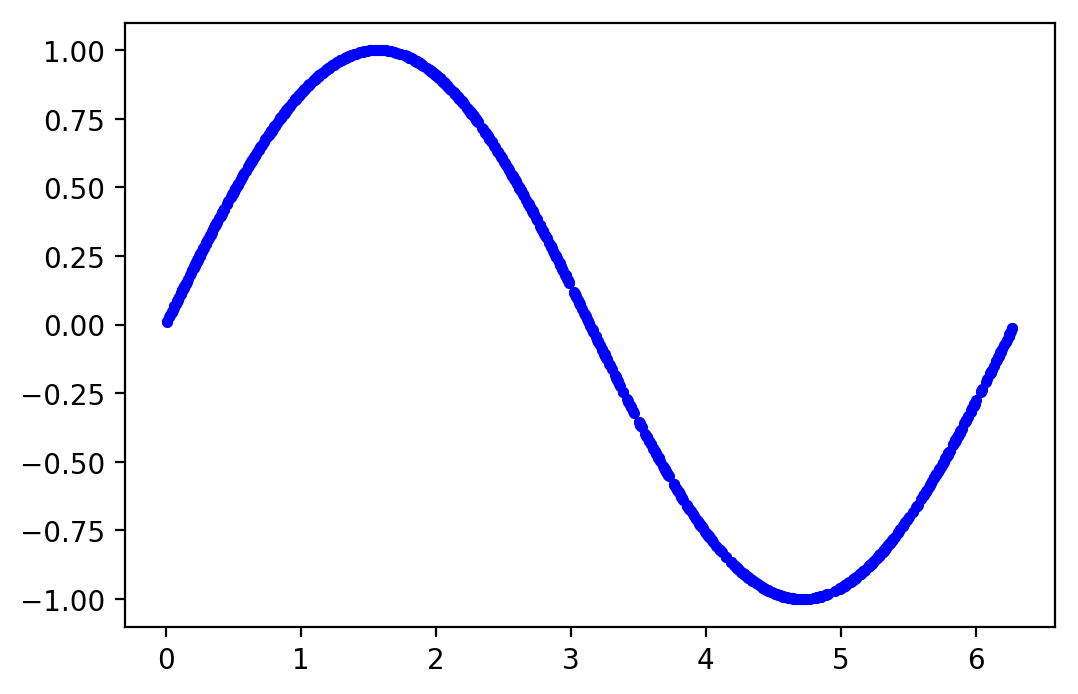

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

x_values = np.random.uniform(low=0, high=2*math.pi, size=1000)
np.random.shuffle(x_values)
y_values = np.sin(x_values)
plt.plot(x_values, y_values, 'b.')
plt.show()

## ノイズをかけて

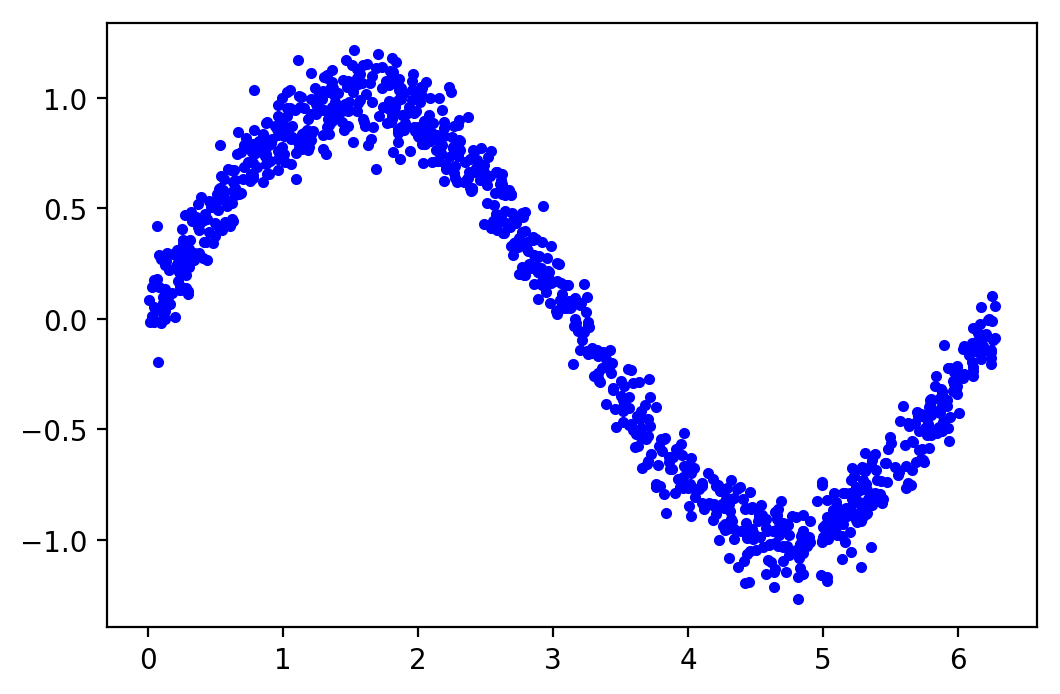

In [3]:
y_values += 0.1 * np.random.randn(*y_values.shape)
plt.plot(x_values, y_values, 'b.')
plt.show()

## datasetをちゃんと分けて

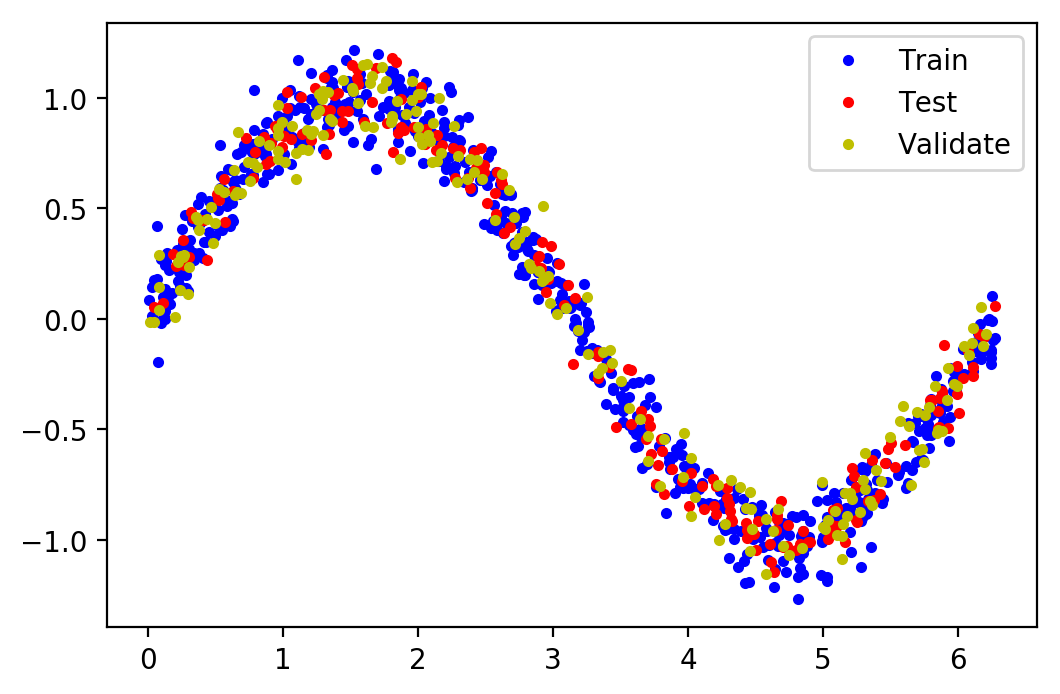

In [4]:
x_train, x_test, x_validate = x_values[:600], x_values[600:800], x_values[800:]
y_train, y_test, y_validate = y_values[:600], y_values[600:800], y_values[800:]

plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()

## Kerasで１０秒を温めて

In [5]:
from tensorflow.keras import layers
import tensorflow as tf
tf.enable_eager_execution()

model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(x_train, y_train, epochs=200, batch_size=16,
                    validation_data=(x_validate, y_validate), verbose=1)

Train on 600 samples, validate on 200 samples
Epoch 1/200
600/600 [==============================] - 1s 885us/sample - loss: 0.3961 - mean_absolute_error: 0.5365 - val_loss: 0.3760 - val_mean_absolute_error: 0.5255
Epoch 2/200
600/600 [==============================] - 0s 217us/sample - loss: 0.3165 - mean_absolute_error: 0.4824 - val_loss: 0.3055 - val_mean_absolute_error: 0.4748
Epoch 3/200
600/600 [==============================] - 0s 235us/sample - loss: 0.2627 - mean_absolute_error: 0.4424 - val_loss: 0.2521 - val_mean_absolute_error: 0.4337
Epoch 4/200
600/600 [==============================] - 0s 216us/sample - loss: 0.2214 - mean_absolute_error: 0.4071 - val_loss: 0.2103 - val_mean_absolute_error: 0.3973
Epoch 5/200
600/600 [==============================] - 0s 219us/sample - loss: 0.1902 - mean_absolute_error: 0.3803 - val_loss: 0.1718 - val_mean_absolute_error: 0.3611
Epoch 6/200
600/600 [==============================] - 0s 211us/sample - loss: 0.1750 - mean_absolute_error: 

## モデルを試して

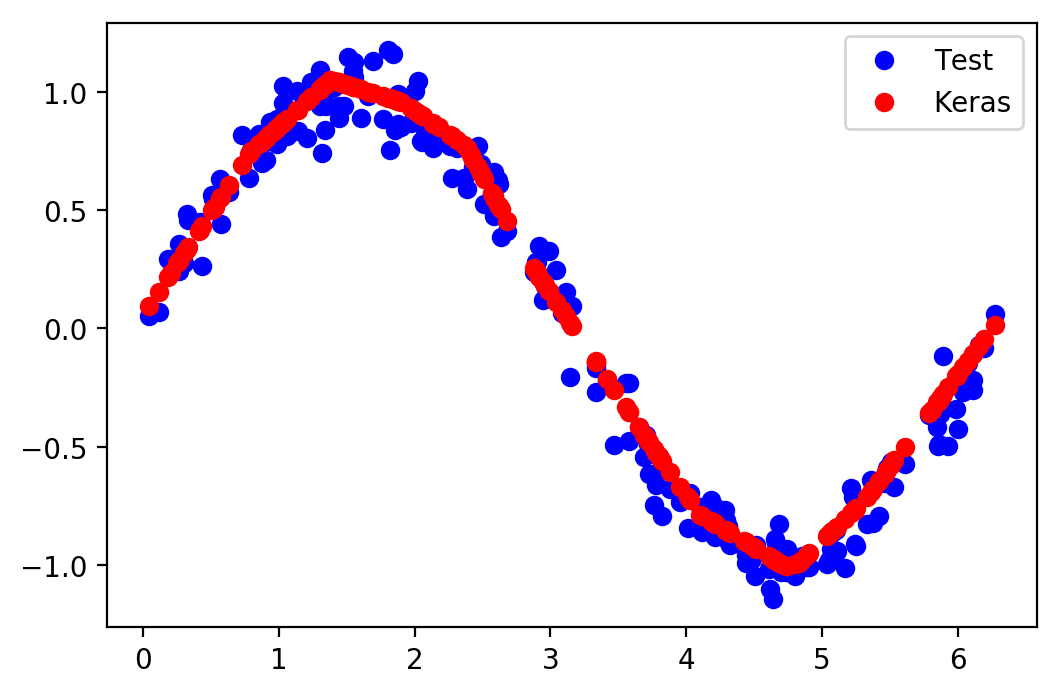

In [6]:
predictions = model.predict(x_test)

plt.clf()
plt.plot(x_test, y_test, 'bo', label='Test')
plt.plot(x_test, predictions, 'ro', label='Keras')
plt.legend()
plt.show()

## tfliteにゆっくり変わって

In [7]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter = tf.compat.v2.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open("sine_model_quantized.tflite", "wb").write(tflite_model)

2604

## マイコンに入れる前に最後の確認

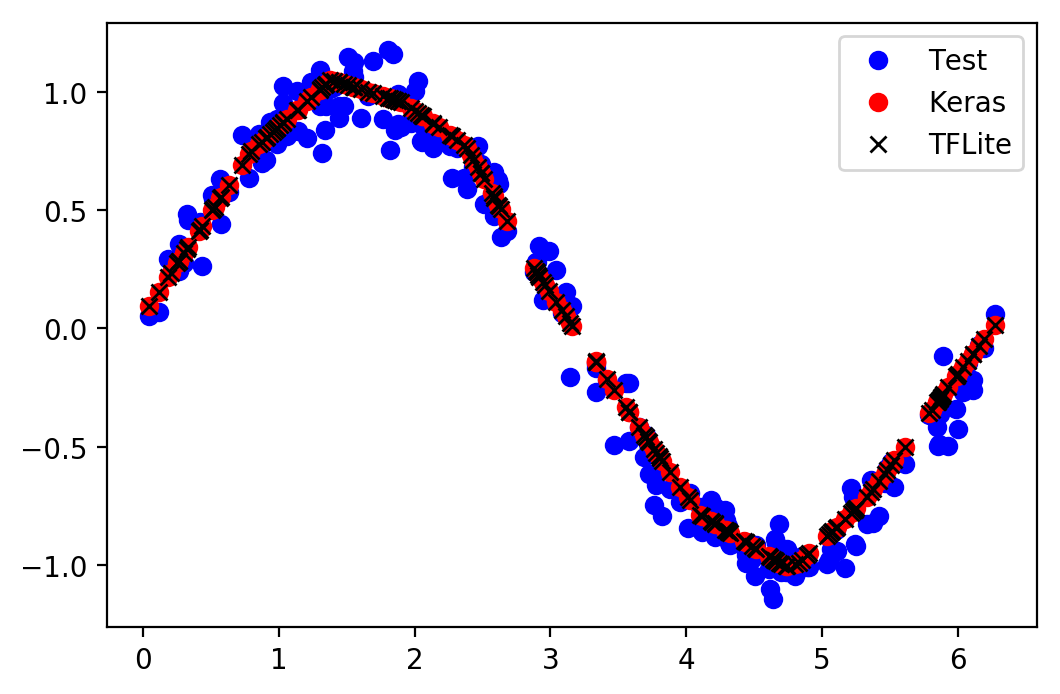

In [8]:
interpreter = tf.lite.Interpreter('sine_model_quantized.tflite')
interpreter.allocate_tensors()
input = interpreter.tensor(interpreter.get_input_details()[0]["index"])
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])
lite_predictions = np.empty(x_test.size)
for i in range(x_test.size):
  input()[0] = x_test[i]
  interpreter.invoke()
  lite_predictions[i] = output()[0]
plt.plot(x_test, y_test, 'bo', label='Test')
plt.plot(x_test, predictions, 'ro', label='Keras')
plt.plot(x_test, lite_predictions, 'kx', label='TFLite')
plt.legend()
plt.show()

## マイコンに入れるために「ANSI C」に変わって

In [9]:
!apt-get install xxd

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xxd is already the newest version (2:8.0.1453-1ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [0]:
! xxd -i sine_model_quantized.tflite > sine_model_data.h

```
unsigned char sine_model_quantized_tflite[] = {
  0x18, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x0e, 0x00,
  0x18, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x0e, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x10, 0x0a, 0x00, 0x00,
  0xb8, 0x05, 0x00, 0x00, 0xa0, 0x05, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x0b, 0x00, 0x00, 0x00, 0x90, 0x05, 0x00, 0x00, 0x7c, 0x05, 0x00, 0x00,
  0x24, 0x05, 0x00, 0x00, 0xd4, 0x04, 0x00, 0x00, 0xc4, 0x00, 0x00, 0x00,
  // ...
}
unsigned int sine_model_quantized_tflite_len = 2640;
```

## Arduinoタイム

`SineSerial.ino`

```
#include "TfLiteMicroArduino.h"
#include "sine_model_data.h"

float angle = 0;

void setup() {
    // ...
}

void loop() {
    // ...
}

```

## tflite microのinterpreterを設定する
```
void setup() {
  Serial.begin(9600);
  TfLiteMicro.begin(g_sine_model_data);
}
```

## モデルを叩く
```
void loop() {
  // ...
  TfLiteMicro.inputFloat(0)[0] = angle;
  TfLiteMicro.invoke();
  Serial.println(TfLiteMicro.outputFloat(0)[0]);
  angle += 0.1f;
  if (angle > 2 * M_PI) {
    angle = 0.0f;
  }
}
```


![plotter](https://github.com/proppy/TfLiteMicroArduino/blob/master/notebooks/plotter.png?raw=1)

## LEDを点ける

```
void setup() {
  // ...
  TfLiteMicro.begin(g_sine_model_data);
  pinMode(PB9, PWM);
}

void loop() {
  // ...
  TfLiteMicro.inputFloat(0)[0] = angle;
  TfLiteMicro.invoke();
  float y = TfLiteMicro.outputFloat(0)[0];
  pwmWrite(PB9, 65535 * (y + 1.0f) / 2.0f);
  angle += 0.01f;
  if (angle > 2 * M_PI) {
    angle = 0.0f;
  }
}
```


![leds](https://github.com/proppy/TfLiteMicroArduino/blob/master/notebooks/leds.gif?raw=1)